In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
import random
import csv
from datetime import datetime
import time

from langchain.schema.runnable import RunnableSequence

In [2]:
# Do imports for squad_scoring and prompts
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))

utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))

utils_folder = Path(".")
sys.path.append(str(utils_folder))

import squad_scoring
import deh_prompts
import deh_vector_store
import deh_squad_data
import deh_hyde
import deh_experiments_config
globals().update(deh_experiments_config.__dict__)
from deh_llm import get_llm

##### Set Global variables

In [3]:
# # Folders for storing data and the results
DATA_ROOT = "../../../deh_data_results/data"         # Set to your own data folder
RESULTS_ROOT = "../../../deh_data_results/results"   # Set to your own results folder
HYDE_BASED_CONTEXTS_ROOT = F"{DATA_ROOT}/hyde_based_contexts"   # Set to your own results folder

# SQuAD dataset
data_file = f"{DATA_ROOT}/dev-v2.0.json"
dataset = squad_scoring.load_dataset(data_file)

# # Vector Store Parameters
VECTOR_STORE_TOP_K = 5
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 100
DEFAULT_CHROMA_PREFIX = "deh_rag"
#DEFAULT_CHROMA_COLLECTION = "per_article"
DEFAULT_CHROMA_COLLECTION = "per_article"
CHUNK_SQUAD_DATASET = False        # Set to True to vectorize the squad dataset. If False, 
                                   # then the documents and their embeddings should already
                                   # exist in the vector store.

# # CONTEXT Creation Parameters
REFRESH_QUESTION_CONTEXTS = False   # Set to True to create question contexts from the vector store; 
                                    # if False, the question contexts are loaded from a csv file.
REFRESH_HYDE_CONTEXTS = False       # Set to True to create hyde contexts; if False,
#                                   # the hyde contexts are loaded from a csv file.                                    

READ_QAS_FROM_FILE = False

# # Bootstrap Parameters
SAMPLE_SIZE = 20
BOOTSTRAPS_N = 10000

# Timing
execution_times_l = []

# Dataframe to store the experiments
df_experiments = pd.DataFrame(experiments).T

# #TODO check if setting the seed makes sense
# # SEED = 42
# # set_seed = random.seed(SEED)

# PERSIST_ANSWER_SAMPLES = False   # Set to True to persist the llm answers for each sample, for each experiment


##### Loading SQuAD data

In [4]:
csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

print(f"Loading squad data...")

column_names = ["title", "squad_context", "qid", "question", "is_impossible", "answer"]
squad_raw = pd.read_csv(f"{DATA_ROOT}/squad_raw.csv", names=column_names, skiprows=1)
df_squad_raw = pd.DataFrame(squad_raw)
df_squad_raw.head(5)

df_titles = pd.DataFrame(df_squad_raw['title'].unique(), columns=["title"])
df_contexts = pd.DataFrame(df_squad_raw['squad_context'].unique(), columns=["squad_context"])
print(f"Number of unique contexts: {len(df_contexts)}")

df_qas = df_squad_raw[['qid', 'question', 'squad_context']].drop_duplicates()
df_qas.head(5)
print(f"Number of unique questions: {len(df_qas)}")
           
            

Loading squad data...
Number of unique contexts: 1204
Number of unique questions: 11858


In [5]:
squad_raw.head()

,title,squad_context,qid,question,is_impossible,answer
0,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
1,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
2,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
3,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,False,France
4,Normans,The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,False,10th and 11th centuries


##### Loading qas with contexts data

In [6]:
# Loading the question contexts from the CSV file
qas_with_contexts_csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

df_qas_with_contexts = pd.read_csv(qas_with_contexts_csv_file_path) #, names=column_names)

# drop the answer column if it exists, since it leads
# to duplicates
if 'answer' in df_qas_with_contexts.columns:
    df_qas_with_contexts = df_qas_with_contexts.drop(columns=['answer'])

df_qas_with_contexts = df_qas_with_contexts.drop_duplicates()
print(f"Rows in dataframe df_qas_with_contexts: {len(df_qas_with_contexts)}")
hyde_articles_cnt = df_qas_with_contexts['hyde_article'].notna().sum()
hyde_based_contexts_cnt = df_qas_with_contexts['hyde_based_context'].notna().sum()
print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

# Rewrite the file, since answer column was removed
df_qas_with_contexts.to_csv(qas_with_contexts_csv_file_path, index=False)


Rows in dataframe df_qas_with_contexts: 1522
Number of questions with Hyde articles: 526
Number of questions with Hyde based contexts: 526


##### Get Hyde data (articles and Hyde-based contetxts)

In [7]:
hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
df_hyde_based_contexts = pd.read_csv(hyde_based_context_path)

print(f"Rows in dataframe df_hyde_based_contexts: {len(df_hyde_based_contexts)}")
hyde_articles_cnt = df_hyde_based_contexts['hyde_article'].notna().sum()
hyde_based_contexts_cnt = df_hyde_based_contexts['hyde_based_context'].notna().sum()
print(f"Number of questions with Hyde articles: {hyde_articles_cnt}")
print(f"Number of questions with Hyde based contexts: {hyde_based_contexts_cnt}")

Rows in dataframe df_hyde_based_contexts: 3924
Number of questions with Hyde articles: 3924
Number of questions with Hyde based contexts: 0


##### Show names of all dataframes

In [8]:
import copy 

print("Names of Dataframes and their lenghts:\n")
global_keys_copy = copy.deepcopy(list(globals().keys()))

my_l = [{n: len(globals()[n])} for n in global_keys_copy if n.startswith("df_")]
df_dfs = pd.DataFrame([(k, v) for d in my_l for k, v in d.items()], columns=['df name', 'rows'])
df_dfs


Names of Dataframes and their lenghts:



,df name,rows
0,df_experiments,7
1,df_squad_raw,26232
2,df_titles,35
3,df_contexts,1204
4,df_qas,11858
5,df_qas_with_contexts,1522
6,df_hyde_based_contexts,3924


##### Intialize the Vector Store (Chroma; Milvus not yet included)

In [9]:
contexts = list(df_contexts["squad_context"].values)
if CHUNK_SQUAD_DATASET:    
    deh_vector_store.chunk_squad_dataset(contexts, dataset, CHUNK_SIZE, CHUNK_OVERLAP)
else:
    print("Chunking not foreseen. Skipping chunking.")

Chunking not foreseen. Skipping chunking.


In [10]:
# Intiialize the Chroma vector store
vector_store = deh_vector_store.get_vector_store(DEFAULT_CHROMA_PREFIX, DEFAULT_CHROMA_COLLECTION)

##### Get hyde-based contexts

Always get hyde-based contexts that already exist and these to the qas dataset

In [11]:
# if not READ_QAS_FROM_FILE:
#     hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
#     hyde_based_contexts, questions_already_processed = deh_hyde.get_hyde_based_contexts(hyde_based_context_path)
#     print(f"Number of questions with hyde-based context: {len(questions_already_processed)}")

In [12]:
# if not READ_QAS_FROM_FILE:
#     # Now add the hyde-based contexts to the qas dataset
#     def get_hyde_based_info_from_qid(qid):
#         for hbc in hyde_based_contexts:
#             if hbc["qid"] == qid:
#                 return (hbc["hyde_article"], hbc["hyde_based_context"])
#         return ("", "")

#     for qa in qas:
#         qid = qa["qid"]
#         hyde_article, hyde_based_context = get_hyde_based_info_from_qid(qid)
#         qa["hyde_article"] = hyde_article
#         qa["hyde_based_context"] = hyde_based_context


##### Normal (i.e. not hyde-based) Question Contexts

Questions:

- if configured, either: generate normal question contexts and then persist
- or: read the question contexts from a .csv file


In [13]:
def persist_question_contexts(qas, csv_file_path):

    # Write the the qas dataset including the question contexts to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        fieldnames = ["title", "context", "qid", "question", "is_impossible",
                      "answer", "hyde_article", "hyde_based_context", "question_context"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()   # Write the header row
        writer.writerows(qas)  # Write the data rows

    print(f"Data successfully written to {csv_file_path}")


In [14]:
# Refresh question contexts (normal contexts and hyde-based contexts)
if REFRESH_QUESTION_CONTEXTS or REFRESH_HYDE_CONTEXTS:
    print(f"Generating question contexts for the dataset and persisting these in a csv file...")

    for i, qa in enumerate(qas):
        if i %100 == 0:
            print(f"Processing question {i}...")

        if REFRESH_QUESTION_CONTEXTS:
            question = qa["question"]
            
            top_docs = vector_store.similarity_search(
                query = question,
                k = VECTOR_STORE_TOP_K,
            )
            qa["question_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

        if REFRESH_HYDE_CONTEXTS:
            hyde_article = qa["hyde_article"]
            if len(hyde_article) > 0:
                #print(f"hyde_article: {hyde_article}")
                top_docs = vector_store.similarity_search(
                    query = hyde_article,
                    k = VECTOR_STORE_TOP_K,
                )

                qa["hyde_based_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

    persist_question_contexts(qas, csv_file_path)



##### Define functions that are needed for experiments

In [15]:
# Create the runnable chain
def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [16]:
# Get the Hyde context for a question
def get_hyde_based_context(question):
    hyde_based_context = df_qas_with_contexts[df_qas_with_contexts["question"] == question]
    if hyde_based_context.empty:
        return None
    else:
        return hyde_based_context["hyde_based_context"].values[0]
    

In [17]:
# # generate the LLM answers, using a runnable chain and the sample of questions provided
# def generate_llm_answers(runnable_chain, qas_sample, hyde=False):
    
#     preds = {}

#     sample_size = len(qas_sample)
#     print(f"sample_size: {sample_size}")

#     for i, qa in enumerate(qas_sample):

#         question = qa["question"]
#         if hyde:
#             #context = qa["hyde_context"]
#             context = get_hyde_based_context(question)
#         else:
#             context = qa["vector_store_context"]
            
#         # print(f"question --> {question}")
#         # print(context)
#         response = runnable_chain.invoke({"context": context, "question": question})
                
#         qid = squad_scoring.get_qid_from_question(question, dataset)
        
#         if response.content.upper() == "DONT KNOW":
#             llm_answer = ""
#         else:
#             llm_answer = response.content

#         preds[qid] = llm_answer
#         qas_sample[i]["llm_answer"] = llm_answer

#     return preds


In [18]:
#%%capture

# Get the metrics for a set of predictions (preds) that have been generated in a run
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]


In [19]:
# Calculate the mean and confidence interval for a list of scores
# TODO: Check if this is calculation is correct !!
def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    sample_std_dev = np.std(scores_l, ddof=1)
    margin_of_error = 1.96 * sample_std_dev
    ci = (max(mean - margin_of_error, 0), min(mean + margin_of_error, 100))
    # if ci[0] < 0:
    #     ci = (0, ci[1])
    # if ci[1] > 100:
    #     ci = (ci[0], 100)

    return mean, ci

In [20]:


# Generate a histogram for a list of scores and persist it
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)

    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N} - Sample Size: {SAMPLE_SIZE})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    max_len = 6
    mean_label = f"{mean: .2f}".rjust(max_len)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1:          {mean_label}')

    # Add vertical lines for the 95% confidence interval
    lower = f"{ci[0]: .2f}".rjust(max_len)
    upper = f"{ci[1]: .2f}".rjust(max_len)
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Lower:  {lower}")
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label=f"95% CI Upper:  {upper}")

    ax = plt.gca()  # Get current axis
    ax.xaxis.set_major_locator(MultipleLocator(10))  # Major ticks every 10 units
    ax.xaxis.set_minor_locator(MultipleLocator(5))   # Minor ticks every 5 units
    ax.yaxis.set_major_locator(MultipleLocator(10))   # Example: Major ticks every 5 units on the y-axis
    #ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(data)))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # Customize grid for major and minor ticks
    ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linestyle=':', linewidth=0.5)

    # Add a legend
    plt.legend(prop={'family': 'monospace', 'size': 10})
    plt.legend(loc='upper right', fontsize=10)

    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))
    return plt

##### Define functions for Bootstrapping

In [21]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [22]:
def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    # add each answer to the all_preds
    preds = {}
    all_preds= {}
    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed:
            if experiment_name == "BASIC_RAG_HYDE":
                context = qa["hyde_based_context"]
            elif experiment_name == "FULL_RAG":
                context = qa["question_context"] + "\n\n" + qa["hyde_based_context"]
            else:
                context = qa["question_context"]
            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        llm_answer = response.content

        if llm_answer.upper() == "DONT KNOW":
            if suppress_answers:
                continue
            else:
                llm_answer = ""

        preds[qid] = llm_answer
        all_preds[qid] = llm_answer

        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        preds = {}
        qa[f"{experiment_name.lower()}_llm_answer"] = llm_answer
        qa[f"{experiment_name.lower()}_f1"] = f1
        qa[f"{experiment_name.lower()}_precision"] = precision
        qa[f"{experiment_name.lower()}_recall"] = recall

    return all_preds
        

In [23]:
def persist_results(results_folder_name, experiment_name, df):

    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)

In [24]:
def clip_scores(scores_l, clip_perc):
    scores_sorted_l = sorted(scores_l)

    clip_cnt = int(len(scores_sorted_l) * clip_perc / 100)
    print(f"clip_cnt: {clip_cnt}")

    # Now clip both ends by clip_perc percent
    clipped_scores_l = scores_sorted_l[clip_cnt:-clip_cnt] if clip_cnt > 0 else scores_sorted_l
    return clipped_scores_l


In [25]:
def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):
    
    mu_hats = []
    n = len(scores_l)
    scores_l = clip_scores(scores_l, 2.5)
    # print(f"scores_l: {scores_l}")
    for i in range(bootstraps_n):
        if i % 100 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    plt = generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)
    plt.show();

In [26]:
def create_results_folder(experiment_name):
    start_timestamp_str = get_timestamp_as_string()
    results_folder_name = f"{RESULTS_ROOT}/{experiment_name}/results_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [27]:
def conduct_experiment(qas, experiment_name, query_prompt_idx, 
                       context_needed=False, hyde_context_needed=False, 
                       suppress_answers=False):

    start_time = time.perf_counter()

    print(f"============= Creating results folder for {experiment_name} =============")
    results_folder_name = create_results_folder(experiment_name)
    
    print(f"============= Calculating scores for {experiment_name} =============")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}\n")
    all_preds = calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, suppress_answers)

    print(f"============= Persisting results for {experiment_name} =============")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df)

    print(f"\n============= Bootstrapping for {experiment_name} =============")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")

    do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)

    end_time = time.perf_counter()
    execution_time = end_time - start_time
    execution_times_entry = {}
    execution_times_entry["experiment_name"] = experiment_name
    execution_times_entry["execution_time"] = execution_time
    execution_times_entry["sample_size"] = SAMPLE_SIZE
    execution_times_entry["bootstrap_n"] = BOOTSTRAPS_N
    execution_times_l.append(execution_times_entry)
    return execution_time

##### Creating a sample from qas for bootstrapping and bootstrapping with Hyde (will be used for all experiments)

In [28]:
df_qas_for_bootstrapping = df_qas_with_contexts[['qid', 'question', 'question_context', 'hyde_based_context']]
df_qas_for_bootstrapping_sample = df_qas_for_bootstrapping.sample(n=SAMPLE_SIZE, replace=True)
ldict_qas_for_boostrapping_sample = df_qas_for_bootstrapping_sample.to_dict(orient='records')

df_qas_for_hyde_bootstrapping = df_qas_for_bootstrapping[df_qas_for_bootstrapping['hyde_based_context'].notna()]
df_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping.sample(n=SAMPLE_SIZE, replace=True)
ldict_qas_for_hyde_bootstrapping_sample = df_qas_for_hyde_bootstrapping_sample.to_dict(orient='records')

sample_ldicts = [ldict_qas_for_boostrapping_sample, ldict_qas_for_hyde_bootstrapping_sample]

##### Conducting all experiments

============= Creating results folder for NO_RAG =============
============= Calculating scores for NO_RAG =============
SAMPLE_SIZE: 20

current_query_prompt = 
    You are an assistant for question-answering tasks.
    Use ten words maximum and keep the answer concise.

    Question: {question}

    Answer:
    

Processing question 0...
Processing question 10...
============= Persisting results for NO_RAG =============

============= Bootstrapping for NO_RAG =============
BOOTSTRAPS_N: 10000
clip_cnt: 0
Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sample 300...
Processing sample 400...
Processing sample 500...
Processing sample 600...
Processing sample 700...
Processing sample 800...
Processing sample 900...
Processing sample 1000...
Processing sample 1100...
Processing sample 1200...
Processing sample 1300...
Processing sample 1400...
Processing sample 1500...
Processing sample 1600...
Processing sample 1700...
Processing sample 1800...
Proces

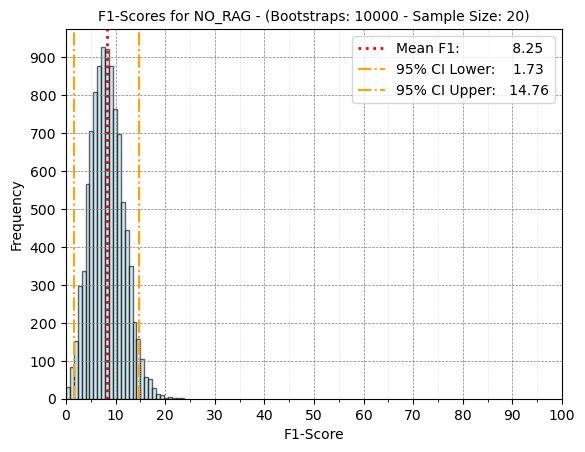

============= Creating results folder for BASIC_RAG_DONT_LIE =============
============= Calculating scores for BASIC_RAG_DONT_LIE =============
SAMPLE_SIZE: 20

current_query_prompt = 
        You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just return 'DONT KNOW'. 
        If you know the answer, keep it as short and concise as possible,
        i.e. to a maximum of a couple of words.

        Question: {question}
        Context: {context}

        Answer:
        

Processing question 0...
Processing question 10...
============= Persisting results for BASIC_RAG_DONT_LIE =============

============= Bootstrapping for BASIC_RAG_DONT_LIE =============
BOOTSTRAPS_N: 10000
clip_cnt: 0
Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sample 300...
Processing sample 400...
Processing sample 500...
Processing sample 600...
Processing samp

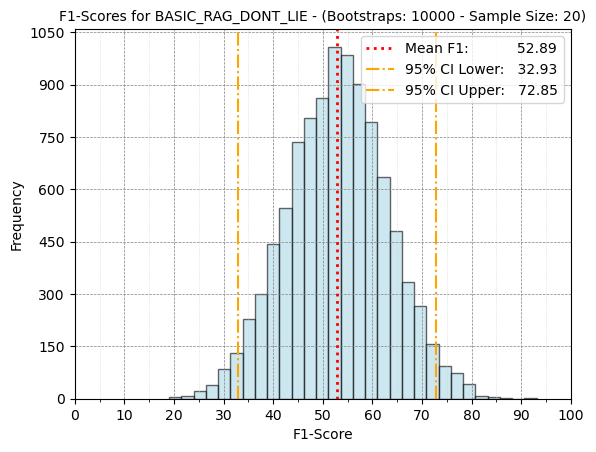

============= Creating results folder for BASIC_RAG_SUPPRESS_ANSWERS =============
============= Calculating scores for BASIC_RAG_SUPPRESS_ANSWERS =============
SAMPLE_SIZE: 20

current_query_prompt = 
        You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just return 'DONT KNOW'. 
        If you know the answer, keep it as short and concise as possible,
        i.e. to a maximum of a couple of words.

        Question: {question}
        Context: {context}

        Answer:
        

Processing question 0...
Processing question 10...
============= Persisting results for BASIC_RAG_SUPPRESS_ANSWERS =============

============= Bootstrapping for BASIC_RAG_SUPPRESS_ANSWERS =============
BOOTSTRAPS_N: 10000
clip_cnt: 0
Processing sample 0...
Processing sample 100...
Processing sample 200...
Processing sample 300...
Processing sample 400...
Processing sample 500...
Processi

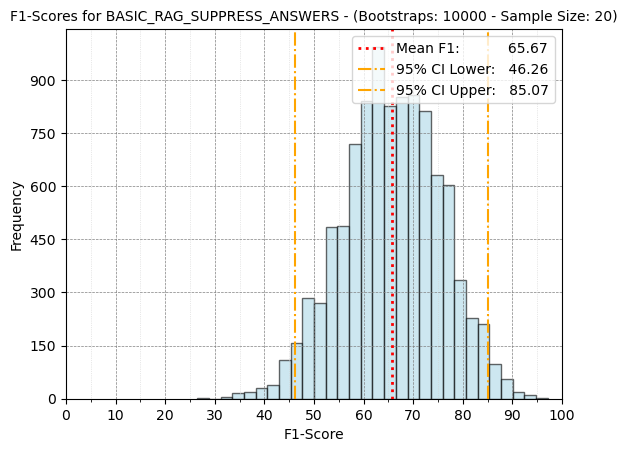


================== Execution times (in seconds): ==================================



,experiment_name,execution_time,sample_size,bootstrap_n
0,NO_RAG,5.93,20,10000
1,BASIC_RAG_DONT_LIE,6.40,20,10000
2,BASIC_RAG_SUPPRESS_ANSWERS,6.24,20,10000


In [29]:
for index, row in df_experiments.iterrows():
    if not row["include"]:
        continue

    sample_ldict = sample_ldicts[row["sample_ldicts_idx"]]
    experiment_name = row["name"]
    query_prompt_idx = row["query_prompt_idx"]
    context_needed = row["context_needed"]
    hyde_context_needed = row["hyde_context_needed"]
    suppress_answsers = row["suppress_answers"]
    
    conduct_experiment(sample_ldict, experiment_name, query_prompt_idx,
                       context_needed, hyde_context_needed, suppress_answsers)

print(f"\n================== Execution times (in seconds): ==================================\n")
df_execution_times = pd.DataFrame(execution_times_l, 
                                  columns=['experiment_name', 'execution_time', 'sample_size', 'bootstrap_n'])

pd.options.display.float_format = "{:.2f}".format
df_execution_times.head(100)                

In [30]:
# Reset the display format for floats
pd.reset_option('display.float_format')

## EXPERIMENTAL 

In [31]:
def generate_llm_judges_score(runnable_chain, qas_sample, hyde=False):
    
    preds = {}

    sample_size = len(qas_sample)
    print(f"sample_size: {sample_size}")

    for i, qa in enumerate(qas_sample):

        question = qa["question"]
        if hyde:
            #context = qa["hyde_context"]
            context = get_hyde_based_context(question)
        else:
            context = qa["vector_store_context"]
            
        # print(f"question --> {question}")
        # print(context)
        response = runnable_chain.invoke({"context": context, "question": question})
                
        qid = squad_scoring.get_qid_from_question(question, dataset)
        
        if response.content.upper() == "DONT KNOW":
            llm_answer = ""
        else:
            llm_answer = response.content

        preds[qid] = llm_answer
        qas_sample[i]["llm_answer"] = llm_answer

    return preds

In [32]:
judge_current_query_prompt = deh_prompts.query_prompts[4]
print(f"judge_current_query_prompt = {judge_current_query_prompt.template}\n")

judge_current_query_prompt = 

You are an impartial and analytical judge tasked with evaluating the correctness of an answer based 
on a given question and context. You first need to assess if given only the context, an answer to the
question is possible at all. If you answer this with 'Yes', then your next task is to evaluate 
the correctness of the answer based on the given question and context. Your judgment should be logical,
well-reasoned, and clear.

Here is the process you should follow:

1.) Carefully read and understand the Question, Context, and Answer provided.

2.) Based on the Context, determine if an Answer is possible at all, based on the context. 
If you believe that an answser is possible, please determine if the provided answer
addresses the question accurately and answers it correctly.

3.) Please conclude with providing exactly two responses based on the descriptions provided 
under a.) and b.) below:

a.) Return 'YES' if you believe that the answer is possible and 

In [33]:
question = "Are the sizes of packets variable?"
context = """
Connection-oriented transmission requires a setup phase in each involved node before any packet is transferred to establish the parameters of communication. The packets include a connection identifier rather than address information and are negotiated between endpoints so that they are delivered in order and with error checking. Address information is only transferred to each node during the connection set-up phase, when the route to the destination is discovered and an entry is added to the switching table in each network node through which the connection passes. The signaling protocols used allow the application to specify its requirements and discover link parameters. Acceptable values for service parameters may be negotiated. Routing a packet requires the node to look up the connection id in a table. The packet header can be small, as it only needs to contain this code and any information, such as length, timestamp, or sequence number, which is different for different packets. Similarly, it is not known if L (the set of all problems that can be solved in logarithmic space) is strictly contained in P or equal to P. Again, there are many complexity classes between the two, such as NL and NC, and it is not known if they are distinct or equal classes. Many types of Turing machines are used to define complexity classes, such as deterministic Turing machines, probabilistic Turing machines, non-deterministic Turing machines, quantum Turing machines, symmetric Turing machines and alternating Turing machines. They are all equally powerful in principle, but when resources (such as time or space) are bounded, some of these may be more powerful than others.

Many machine models different from the standard multi-tape Turing machines have been proposed in the literature, for example random access machines. Perhaps surprisingly, each of these models can be converted to another without providing any extra computational power. The time and memory consumption of these alternate models may vary. What all these models have in common is that the machines operate deterministically. It is tempting to think that the notion of function problems is much richer than the notion of decision problems. However, this is not really the case, since function problems can be recast as decision problems. For example, the multiplication of two integers can be expressed as the set of triples (a, b, c) such that the relation a × b = c holds. Deciding whether a given triple is a member of this set corresponds to solving the problem of multiplying two numbers. To measure the difficulty of solving a computational problem, one may wish to see how much time the best algorithm requires to solve the problem. However, the running time may, in general, depend on the instance. In particular, larger instances will require more time to solve. Thus the time required to solve a problem (or the space required, or any measure of complexity) is calculated as a function of the size of the instance. This is usually taken to be the size of the input in bits. Complexity theory is interested in how algorithms scale with an increase in the input size. For instance, in the problem of finding whether a graph is connected, how much more time does it take to solve a problem for a graph with 2n vertices compared to the time taken for a graph with n vertices?
"""

answer = "Yes, packet sizes can vary depending on context."

judge_chain = judge_current_query_prompt | get_llm(judge_current_query_prompt, True)
response = judge_chain.invoke({"context": context, "question": question, "answer": answer})


In [34]:
a = response.content
for i in range (0, len(a), 100):
    print(a[i:i+100])

 (Yes, 1)


In [35]:
question = "What molecules are repelled by pathogenic antigens?"
context = "Both innate and adaptive immunity depend on the ability of the immune system to distinguish between self and non-self molecules. In immunology, self molecules are those components of an organism's body that can be distinguished from foreign substances by the immune system. Conversely, non-self molecules are those recognized as foreign molecules. One class of non-self molecules are called antigens (short for antibody generators) and are defined as substances that bind to specific immune receptors and elicit an immune response. A B cell identifies pathogens when antibodies on its surface bind to a specific foreign antigen. This antigen/antibody complex is taken up by the B cell and processed by proteolysis into peptides. The B cell then displays these antigenic peptides on its surface MHC class II molecules. This combination of MHC and antigen attracts a matching helper T cell, which releases lymphokines and activates the B cell. As the activated B cell then begins to divide, its offspring (plasma cells) secrete millions of copies of the antibody that recognizes this antigen. These antibodies circulate in blood plasma and lymph, bind to pathogens expressing the antigen and mark them for destruction by complement activation or for uptake and destruction by phagocytes. Antibodies can also neutralize challenges directly, by binding to bacterial toxins or by interfering with the receptors that viruses and bacteria use to infect cells. The immune system protects organisms from infection with layered defenses of increasing specificity. In simple terms, physical barriers prevent pathogens such as bacteria and viruses from entering the organism. If a pathogen breaches these barriers, the innate immune system provides an immediate, but non-specific response. Innate immune systems are found in all plants and animals. If pathogens successfully evade the innate response, vertebrates possess a second layer of protection, the adaptive immune system, which is activated by the innate response. Here, the immune system adapts its response during an infection to improve its recognition of the pathogen. This improved response is then retained after the pathogen has been eliminated, in the form of an immunological memory, and allows the adaptive immune system to mount faster and stronger attacks each time this pathogen is encountered. Clearly, some tumors evade the immune system and go on to become cancers. Tumor cells often have a reduced number of MHC class I molecules on their surface, thus avoiding detection by killer T cells. Some tumor cells also release products that inhibit the immune response; for example by secreting the cytokine TGF-β, which suppresses the activity of macrophages and lymphocytes. In addition, immunological tolerance may develop against tumor antigens, so the immune system no longer attacks the tumor cells. Microorganisms or toxins that successfully enter an organism encounter the cells and mechanisms of the innate immune system. The innate response is usually triggered when microbes are identified by pattern recognition receptors, which recognize components that are conserved among broad groups of microorganisms, or when damaged, injured or stressed cells send out alarm signals, many of which (but not all) are recognized by the same receptors as those that recognize pathogens. Innate immune defenses are non-specific, meaning these systems respond to pathogens in a generic way. This system does not confer long-lasting immunity against a pathogen. The innate immune system is the dominant system of host defense in most organisms."
answser = "Antibodies."

In [43]:
answer = "Yes, packet sizes can vary depending on context."

judge_chain = judge_current_query_prompt | get_llm(judge_current_query_prompt, True)
response = judge_chain.invoke({"context": context, "question": question, "answer": answer})

In [44]:
a = response.content
for i in range (0, len(a), 100):
    print(a[i:i+100])

 (No, 0)


In [38]:
response

AIMessage(content=' (No, 0)', additional_kwargs={}, response_metadata={'model': 'mistral:latest', 'created_at': '2024-12-04T07:42:16.450160578Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 349534143, 'load_duration': 3968046, 'prompt_eval_count': 1371, 'prompt_eval_duration': 192000000, 'eval_count': 7, 'eval_duration': 152000000}, id='run-a9951764-fe93-4078-846e-293b151c0b4a-0', usage_metadata={'input_tokens': 1371, 'output_tokens': 7, 'total_tokens': 1378})

In [39]:
print(judge_current_query_prompt.template)



You are an impartial and analytical judge tasked with evaluating the correctness of an answer based 
on a given question and context. You first need to assess if given only the context, an answer to the
question is possible at all. If you answer this with 'Yes', then your next task is to evaluate 
the correctness of the answer based on the given question and context. Your judgment should be logical,
well-reasoned, and clear.

Here is the process you should follow:

1.) Carefully read and understand the Question, Context, and Answer provided.

2.) Based on the Context, determine if an Answer is possible at all, based on the context. 
If you believe that an answser is possible, please determine if the provided answer
addresses the question accurately and answers it correctly.

3.) Please conclude with providing exactly two responses based on the descriptions provided 
under a.) and b.) below:

a.) Return 'YES' if you believe that the answer is possible and correct, 'NO' else. By all me

In [40]:
tuple(response.content)

(' ', '(', 'N', 'o', ',', ' ', '0', ')')

In [41]:
def convert_string_to_answer_tuple(input_string):
    # Trim whitespace
    parts = input_string.strip()
    # Remove parentheses
    parts = parts.strip("()")
    # Split on comma
    parts = parts.split(", ")
    if len(parts) != 2:
        #raise ValueError("Invalid answer string")
        return ("NO", 0)

    answer = parts[0].strip().upper()  # "Yes" or "No"
    if answer not in ["YES", "NO"]:
        #raise ValueError("Invalid answer string")
        return ("NO", 0)
    try:
        score = float(parts[1])  # Convert score to a float
    except ValueError:
        return ("NO", 0)
    
    return (answer, score)

In [42]:
a, s = convert_string_to_answer_tuple(response.content)
print(a)
print(s)

NO
0.0
